# Article Topic Classification

In [49]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree
from collections import Counter
import matplotlib.pyplot as plt

In [50]:
dataset = Planetoid(root="./datasets/", name="Cora")
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [51]:
degrees  = degree(data.edge_index[0]).numpy()
degrees

array([3., 3., 5., ..., 1., 4., 4.], dtype=float32)

In [52]:
numbers = Counter(degrees)
numbers

Counter({2.0: 583,
         3.0: 553,
         1.0: 485,
         4.0: 389,
         5.0: 281,
         6.0: 131,
         7.0: 82,
         8.0: 57,
         10.0: 26,
         9.0: 25,
         12.0: 18,
         11.0: 14,
         17.0: 8,
         16.0: 7,
         14.0: 6,
         15.0: 6,
         19.0: 5,
         13.0: 5,
         21.0: 3,
         18.0: 3,
         23.0: 3,
         32.0: 2,
         30.0: 2,
         36.0: 1,
         78.0: 1,
         33.0: 1,
         29.0: 1,
         34.0: 1,
         26.0: 1,
         168.0: 1,
         22.0: 1,
         42.0: 1,
         74.0: 1,
         44.0: 1,
         31.0: 1,
         65.0: 1,
         40.0: 1})

<BarContainer object of 37 artists>

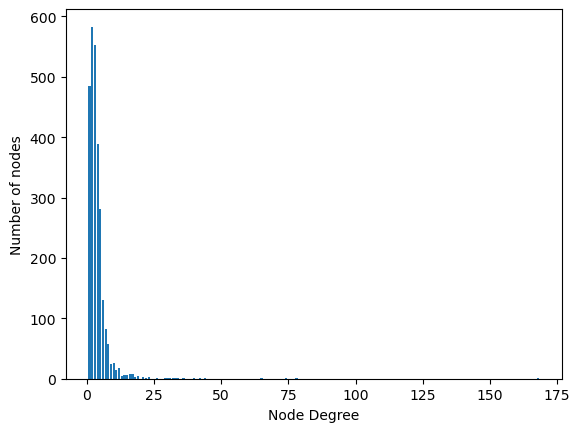

In [53]:
fig, ax = plt.subplots()
ax.set_xlabel('Node Degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(), numbers.values())

In [54]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [55]:
def accuracy(pred_y, y):
  return ((pred_y == y).sum()/len(y)).item()

In [56]:
class GCN(torch.nn.Module):
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h,dim_out)

  def forward(self, x, edge_index):
    h = self.gcn1(x, edge_index)
    h = torch.relu(h)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(self.parameters(),
                                 lr=0.01,
                                 weight_decay=5e-4)
    self.train()
    
    for epoch in range(epochs + 1):
      optimizer.zero_grad()
      out = self.forward(data.x, data.edge_index)
      
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
      
      loss.backward()
      optimizer.step()

      if (epoch % 20 == 0):
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        print(f'Epoch{epoch :> 3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:>5.2f}% | Val Loss: {val_loss:.2f} | Val Acc : {val_acc*100:.2f}%')

  @torch.no_grad()
  def test(self, data):
    self.eval()
    out = self(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [57]:
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
gcn

GCN(
  (gcn1): GCNConv(1433, 16)
  (gcn2): GCNConv(16, 7)
)

In [58]:
gcn.fit(data, epochs=100)

Epoch  0 | Train Loss: 1.958 | Train Acc:  7.14% | Val Loss: 1.97 | Val Acc : 5.00%
Epoch 20 | Train Loss: 0.200 | Train Acc: 100.00% | Val Loss: 0.92 | Val Acc : 74.60%
Epoch 40 | Train Loss: 0.021 | Train Acc: 100.00% | Val Loss: 0.78 | Val Acc : 76.20%
Epoch 60 | Train Loss: 0.017 | Train Acc: 100.00% | Val Loss: 0.75 | Val Acc : 75.80%
Epoch 80 | Train Loss: 0.019 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc : 76.60%
Epoch 100 | Train Loss: 0.018 | Train Acc: 100.00% | Val Loss: 0.73 | Val Acc : 76.60%


In [59]:
acc = gcn.test(data)
acc * 100

79.90000247955322

In [60]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [61]:
# import networkx as nx
# from torch_geometric.utils import to_networkx
# import matplotlib.pyplot as plt

# plt.figure(figsize=(200, 200))

# labels = [node.item() for node in data.y]
# nx_graph = to_networkx(data)

# nx.draw(
#     nx_graph,
#     pos=nx.spring_layout(nx_graph),
#     node_color=labels,
#     # node_size=10,
#     cmap='coolwarm',
#     # font_size=11,
#     # font_color='white',
#     with_labels=False,
# )